# Niveles de Toxicidad en los Tweets de los políticos Españoles


* En este notebook se va a analizar el nivel de toxicidad de los tweets que escriben los políticos españoles.


* Los tweets se van a obtener del dataset de Kaggle "Tweets Política España": https://www.kaggle.com/datasets/ricardomoya/tweets-poltica-espaa


* El modelo de NLP (ya entrenado) que asignará el score de toxicidad a los tweets se va a obtener de: https://huggingface.co/Newtral/xlm-r-finetuned-toxic-political-tweets-es


* El modelo ya entrenado, es un modelo compartido en HuggingFace por la empresa Newtral (https://www.newtral.es/)


* Los detalles de la implementación del notebook y conclusiones de los resultados obtenidos los podéis consultar en el siguiente post: https://jarroba.com/toxicidad-politica-en-tweets/


<hr>

# 1.- Instalación de las librerías

* Estas librerías las vamos a instalar en un entorno virtual con Python 3.7

In [ ]:
!pip install tweet-preprocessor==0.6.0 --user
!pip install transformers==4.17.0 --user
!pip install opendatasets==0.1.22 --user
!pip install tqdm --user

<hr>


# 2.- Lectura de los tweets

* Los tweets los vamos a descargar de: https://www.kaggle.com/datasets/ricardomoya/tweets-poltica-espaa


* Para ello se necesita el usuario de Kaggle y un API key que se obtiene en la cuenta del usuario. Para más info: https://github.com/JovianML/opendatasets/blob/master/README.md#kaggle-credentials

In [1]:
import pandas as pd
import opendatasets as od

# Descagamos el Dataset de Kaggle
od.download('https://www.kaggle.com/datasets/ricardomoya/tweets-poltica-espaa', force=True)

# Cargamos los tweets en un dataframe
df = pd.read_table('./tweets-poltica-espaa/tweets_politica_kaggle.csv',
                   sep='\t', 
                   header=0, 
                   engine='python')

print('\nNúmero de Tweets: {}'.format(df.shape[0]))
df.sample(5)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ricardomoya
Your Kaggle Key: ········


100%|█████████████████████████████████████████████████████████████████████████████| 17.4M/17.4M [00:01<00:00, 17.8MB/s]




Número de Tweets: 181504


,cuenta,partido,timestamp,tweet
6090,8fbbab0ad3015a97ca31cefec4bba92a,podemos,1.560067e+09,Detrás de este tipo de sanciones se esconde el...
66596,83cf0322f4bf4a9533a01b708f437910,pp,1.585391e+09,@RufoCaricaturas Ohhh!!! Texas!!
76871,d575d7c6688df8eefc937cdabf7d7eb9,vox,1.611433e+09,"📺 Este domingo a las 22:00, nuevo programa de ..."
89622,fdce0be92377e5874e04584c4eac7461,psoe,1.616050e+09,@FuRiA_1983 @DiarioCyLMundo Porque el 51% rest...
156998,45929e569b528cfdb28bd08df7c5a780,vox,1.642432e+09,@Astigar3 La gallina


* Porcentaje de Tweets por Partido Político

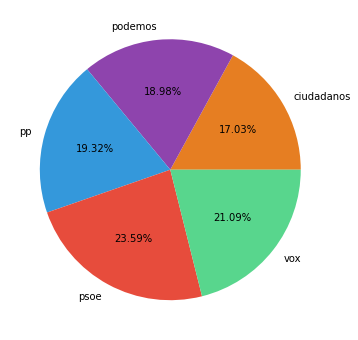

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Conteo de tweets por partido político
df_agg = df.groupby('partido')['tweet'].count().reset_index()

# Pintamos en una gráfica de sectores los resultados
colors={'psoe':'#E74C3C', 'pp':'#3498DB', 'vox':'#58D68D', 'podemos':'#8E44AD', 'ciudadanos':'#E67E22'}
plt.figure(figsize=(12, 6))
plt.pie(x=df_agg['tweet'].values, 
        labels=df_agg['partido'].values, 
        colors=[colors[key] for key in df_agg['partido'].values],
        autopct='%1.2f%%')
plt.show()

<hr>

# 3.- Limpieza de los tweets: Quitamos enlaces, menciones, hastags, emoticonos, etc.


* Usaremos la librería "tweet-preprocesor" (https://pypi.org/project/tweet-preprocessor/) para realizar una limpieza de los tweets eliminando las URLs, Menciones, Hashtags, Emoticonos, etc.


* Con esta limpieza "ayudaremos" al modelo en el proceso de predicción del score, eliminando texto que "seguramente" no le será relevante para calcular la predicción.


In [3]:
import preprocessor as p
import unidecode
from tqdm import tqdm


# Configuramos tweet-preprocessor para que nos elimine del tweet: Urls, menciones, emoticonos, etc.
p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.HASHTAG, p.OPT.EMOJI, p.OPT.SMILEY, p.OPT.ESCAPE_CHAR)

# Limpiamos los tweets
for i in tqdm(range(df.shape[0])):
    # Limpiamos el tweet con tweet-preprocessor y lo pasamos a minúsculas
    df.loc[i, 'clean_tweet'] = (p.clean(unidecode.unidecode(df.iloc[i]['tweet'].lower())))

# Checkpoint
df[['partido', 'timestamp', 'tweet', 'clean_tweet']].to_csv('tweets_clean.csv', sep='\t', index=False)

df[['partido', 'timestamp', 'tweet', 'clean_tweet']].sample(5)

100%|█████████████████████████████████████████████████████████████████████████| 181504/181504 [20:04<00:00, 150.64it/s]


,partido,timestamp,tweet,clean_tweet
12636,psoe,1.563798e+09,@pablocasado_ “La desigualdad la ha generado e...,"""la desigualdad la ha generado el desempleo,o ..."
131858,podemos,1.633785e+09,"""Lo que realmente fastidió del hecho de que me...","""lo que realmente fastidio del hecho de que me..."
155677,ciudadanos,1.642000e+09,@TweetingEGG13 https://t.co/Yev0UceT9z,
12946,ciudadanos,1.563905e+09,Es el ansia viva. https://t.co/apml4gGoBq,es el ansia viva.
27279,psoe,1.571799e+09,@Irene_Montero_ Esto no es apoyar la política ...,esto no es apoyar la politica publica de vivie...


<hr>

# 4.- Predicción de la toxicidad de los tweets


* Vamos a importar el modelo de ***Newtral*** (basado en RoBERTa) que asigna a cada tweet una puntuación de toxicidad.


* Este modelo asigna una puntuación de "Toxic" (LABEL_0) y "Very Toxic" (LABEL_1) a un tweet.


* Los detalles de este modelo lo tenemos en: Los detalles de este modelo están en: https://huggingface.co/Newtral/xlm-r-finetuned-toxic-political-tweets-es

In [ ]:
from transformers import pipeline

# Importamos el modelo
toxicity_scorer = pipeline("text-classification",
                           model="Newtral/xlm-r-finetuned-toxic-political-tweets-es")

# Obtenemos los scores de cada uno de los tweets
for i in tqdm(range(df.shape[0])):
    score = toxicity_scorer(df.iloc[i]['clean_tweet'], return_all_scores=True)
    df.loc[i, 'toxic'] = score[0][0]['score']
    df.loc[i, 'very_toxic'] = score[0][1]['score']
    df.loc[i, 'toxic_score'] = score[0][0]['score'] + score[0][1]['score']

# Checkpoint
(df[['partido', 'timestamp', 'tweet', 'clean_tweet', 'toxic', 'very_toxic', 'toxic_score']]
 .to_csv('tweets_toxicity_scored.csv', sep='\t', index=False))

 29%|█████████████████████▏                                                   | 52719/181504 [50:16<1:46:55, 20.07it/s]

<hr>

# 5.- Ranking de Tweets más Tóxicos


* Hemos creado en el dataframe donde guardamos los tweets y los scores proporcionados por el modelo, una nueva columna llamada "***toxic_score***" que será la suma de los dos scores proporcionados por el modelo ("Toxic" y "Very Toxic").


* Con este nuevo score combinado, realizaremos los análisis de toxicidad.

In [4]:
from datetime import datetime

# Ordenamos los tweets por toxicidad de mayor a menor
# df_rank = df.sort_values('toxic_score', ascending=False).reset_index()
df_rank = df.sort_values('toxic_score', ascending=False).reset_index()

# Mostramos los 10 tweets más tóxicos según el modelo
TOP = 10
for i in range(TOP):
    print('{}º Posición:'.format(i+1))
    print('\tPartido Político: {}'.format(df_rank.iloc[i]['partido'].upper()))
    print('\tFecha: {}'.format(datetime.fromtimestamp(int(df_rank.iloc[i]['timestamp'])).strftime('%d-%m-%Y')))
    print('\tScore: {:.6f}'.format(df_rank.iloc[i]['toxic_score']))
    print('\tTweet: {}\n'.format(df_rank.iloc[i]['tweet']))
    print('----------------------------------------------------------------------------')

1º Posición:
	Partido Político: CIUDADANOS
	Fecha: 20-06-2019
	Score: 1.991903
	Tweet: Que es como decir que el castellano es la lengua de las putas y los camellos. Una nueva ocurrencia de la fanática que quemó la Constitución en TV3.Estáis rociando Cataluña de gasolina desde hace décadas, Empar. Un día saltará una chispa. https://t.co/uKuIjpYkka

----------------------------------------------------------------------------
2º Posición:
	Partido Político: VOX
	Fecha: 03-12-2019
	Score: 1.991774
	Tweet: Lamentable es que dejárais a los separatistas dar un golpe de Estado y sentárais las bases para el segundo. Tuit ridiculo. ¿Pero no eramos fachas irredentos? Sois trileros y desleales, y la gente lo sabe.¿Todo para azuzar el miedo? Si tenéis miedo, apartaos, ¡que vamos! https://t.co/SBDNmZ53Ce

----------------------------------------------------------------------------
3º Posición:
	Partido Político: CIUDADANOS
	Fecha: 03-05-2021
	Score: 1.991752
	Tweet: Para ser un auténtico oprimido ti

<hr>

# 6.- Toxidad media por partido político

In [5]:
df_agg = (df_rank
          .groupby('partido')['toxic_score']
          .mean()
          .reset_index()
          .sort_values('toxic_score', ascending=False))
df_agg

,partido,toxic_score
4,vox,0.656955
0,ciudadanos,0.423100
2,pp,0.368425
1,podemos,0.321112
3,psoe,0.202137


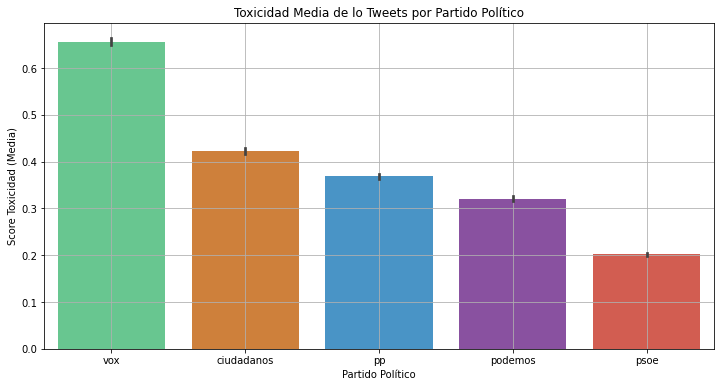

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x="partido", 
            y="toxic_score", 
            data=df_rank, 
            order=df_agg['partido'], 
            palette=colors)
ax.set_title('Toxicidad Media de lo Tweets por Partido Político')
ax.set_ylabel('Score Toxicidad (Media)')
ax.set_xlabel('Partido Político')
ax.grid()

* Distribución de la toxicidad por partido político.

Text(0.5, 0, 'Partido Político')

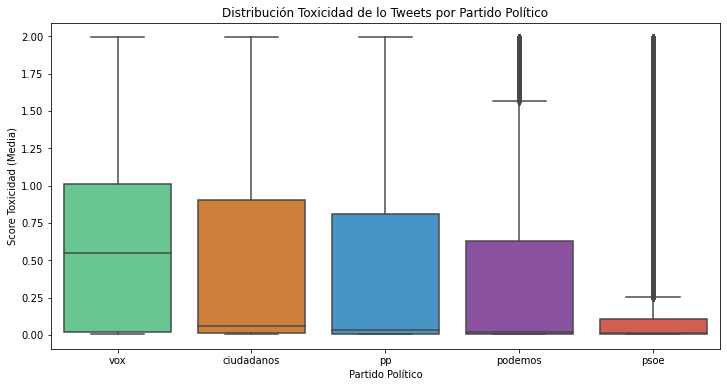

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x="partido", 
               y="toxic_score", 
               data=df_rank, 
               order=df_agg['partido'],
               palette=colors)

ax.set_title('Distribución Toxicidad de lo Tweets por Partido Político')
ax.set_ylabel('Score Toxicidad (Media)')
ax.set_xlabel('Partido Político')